# Google's Qiuck Draw Dataset, CNN Training and Analysis

In [4]:
import datetime, os
from pathlib import Path

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# tensorflow imports :_)
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# this is a quickdraw api that allows us to download our data
from quickdraw import QuickDrawDataGroup, QuickDrawData

## Exploring Quick Draw API

In [5]:
QuickDrawData().drawing_names

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball bat',
 'baseball',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

## Downloading Quick Draw dataset

In [6]:
# Constants
IMAGE_SIZE = (28, 28)
MAX_PER_CATEGORY = 5000  # Limit per category due to ram and space
DATASET_PATH = 'dataset/'
RECOGNIZED_ONLY = True

In [7]:
# using the quick draw data to download the images
for label in QuickDrawData().drawing_names:
    directory = Path(DATASET_PATH + label)
    png_files = list(directory.glob("*.png"))

    if not directory.exists():
        directory.mkdir(parents=True)
    else:
        # if folder is there but it doens't have all the files we need to check :P (I messed up here many times)
        if len(png_files) >= MAX_PER_CATEGORY:
            print(f"Skipping {label}, already has {len(png_files)} PNG files.")
            continue
        
        print(f"Processing {label}, found {len(png_files)} PNG files.")

    images = QuickDrawDataGroup(label, max_drawings=MAX_PER_CATEGORY, recognized=RECOGNIZED_ONLY)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        
        # lets check if we already have that file
        if filename.split("/")[:-1] in png_files:
            continue 
        
        # I need to resize the image to use it for our CNN Model
        img.get_image(stroke_width=3).resize(IMAGE_SIZE).save(filename)
        
        
print("Finished Downloading Dataset!")


Skipping aircraft carrier, already has 5000 PNG files.
Skipping airplane, already has 5000 PNG files.
Skipping alarm clock, already has 5000 PNG files.
Skipping ambulance, already has 5000 PNG files.
Skipping angel, already has 5000 PNG files.
Skipping animal migration, already has 5000 PNG files.
Skipping ant, already has 5000 PNG files.
Skipping anvil, already has 5000 PNG files.
Skipping apple, already has 5000 PNG files.
Skipping arm, already has 5000 PNG files.
Skipping asparagus, already has 5000 PNG files.
Skipping axe, already has 5000 PNG files.
Skipping backpack, already has 5000 PNG files.
Skipping banana, already has 5000 PNG files.
Skipping bandage, already has 5000 PNG files.
Skipping barn, already has 5000 PNG files.
Skipping baseball bat, already has 5000 PNG files.
Skipping baseball, already has 5000 PNG files.
Skipping basket, already has 5000 PNG files.
Skipping basketball, already has 5000 PNG files.
Skipping bat, already has 5000 PNG files.
Skipping bathtub, alread

## Dataset pre-processing / visualization 

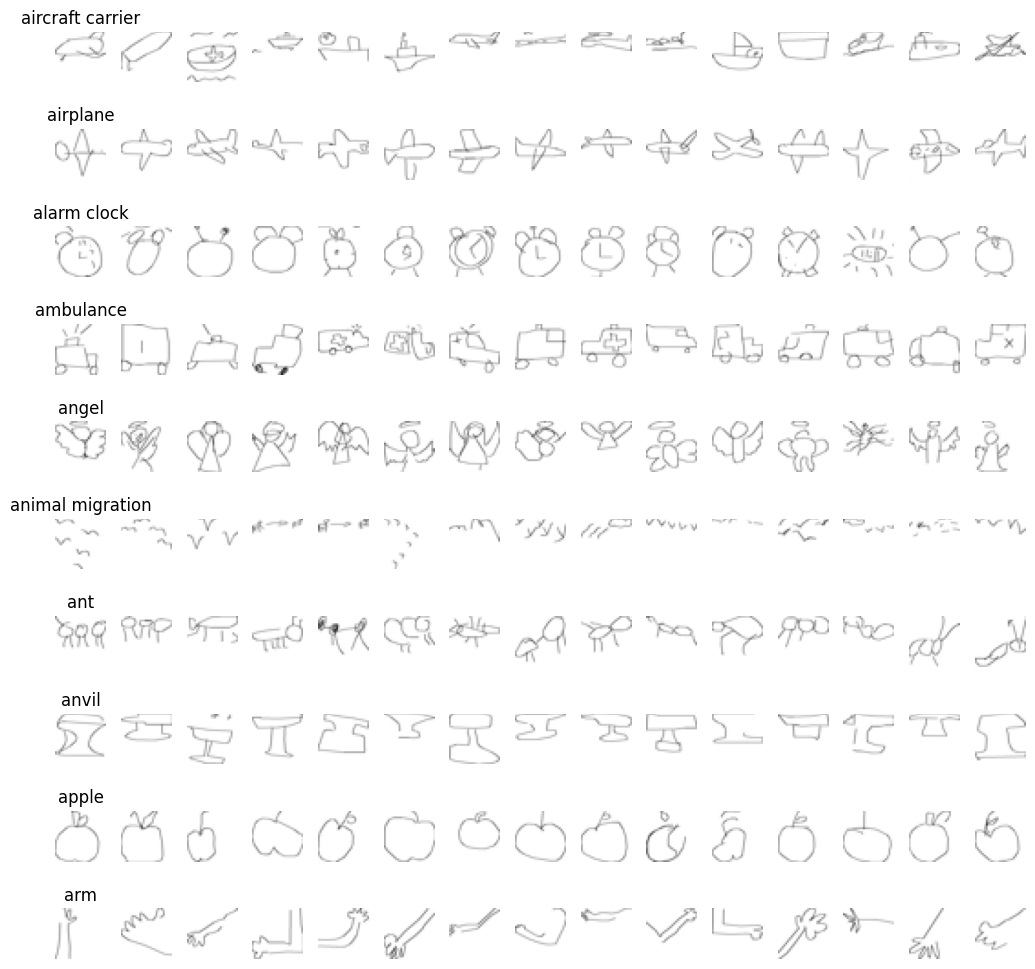

In [8]:
# lets take a look at the images!
def display_sample_images(data_path, categories, num_images=15):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(10, len(categories)))
    for i, category in enumerate(categories):
        category_path = Path(data_path) / category
        image_files = list(category_path.glob("*.png"))[:num_images]
        for j, image_file in enumerate(image_files):
            img = plt.imread(image_file)
            ax = axes[i, j] if len(categories) > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(category if j == 0 else "")
    plt.tight_layout()
    plt.show()

# we only want to see 10 categories
display_sample_images(DATASET_PATH, QuickDrawData().drawing_names[:10])

## Building CNN Model

In [9]:
# CONSTANTS
BATCH_SIZE = 32
INPUT_SHAPE = (28, 28, 1)
NUM_CLASSES = 345

In [10]:
# creating a training dataset
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# creating a validation dataset
val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


global model

# creating a squential model
model = Sequential([
    Rescaling(1. / 255, input_shape=INPUT_SHAPE),
    BatchNormalization(),

    Conv2D(20, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(30, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(NUM_CLASSES, activation='softmax')
])

# compiling our model for training
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(), # https://rmoklesur.medium.com/what-you-need-to-know-about-sparse-categorical-cross-entropy-9f07497e3a6f#:~:text=Sparse%20categorical%20cross%2Dentropy%20is%20an%20extension%20of%20the%20categorical,a%20one%2Dhot%20encoded%20vector.
    metrics=["accuracy"]
)

# print out a summary for viewers :P
model.summary()

Found 1725000 files belonging to 345 classes.
Using 1380000 files for training.
Found 1725000 files belonging to 345 classes.
Using 345000 files for validation.


C:\Users\alvaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 20)     │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 30)     │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 40)       │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       184,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 345)            │        88,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,531 (1.62 MB)

 Trainable params: 422,913 (1.61 MB)

 Non-trainable params: 1,618 (6.32 KB)

## Training CNN Model

In [11]:
EPOCHS = 120
BATCH_SIZE = 50
PATIENCE = 5

def train_cnn(model): 
    # i want to check if there is a path that exists that means we have preivous data
    checkpoint_filepath = os.path.join("cnn/checkpoints/", "quickdraw_cnn_model.keras")
    if Path(checkpoint_filepath).exists():
        print("Previous training data was found!")
        
        user_input = input("Would you like to start where you left off? (Y/n)")
        if user_input == "y" or user_input == "Y": 
            model = tf.keras.models.load_model(checkpoint_filepath)
        
    # checkpoint just in case we break
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,  # Save entire model
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    model_early_stop_callback = EarlyStopping(
        monitor="val_loss",  
        patience=PATIENCE,     
        restore_best_weights=True
    )

    # this where we train the model!
    print("Training CNN Model ...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1,
        batch_size=BATCH_SIZE,
        callbacks=[model_checkpoint_callback, model_early_stop_callback])
    print("Finished Training!")

    # we need to save the model for later testing
    model.save('./cnn/model/quickdraw_cnn_model.h5')
    
    return history
        

history = None
# if a model was found we want to ask if we want to load it and end this cell
models_filepath = os.path.join("cnn/model/", "quickdraw_cnn_model.h5")
if Path(models_filepath).exists():
    print("A saved model was found!")
    user_input = input("Do you want to load the model? (Y/n)")
    if user_input == "y" or user_input == "Y": 
        model = tf.keras.models.load_model(models_filepath)  
    else:
        history = train_cnn(model)
else: 
    history = train_cnn(model)

A saved model was found!


## CNN Model Anaylsis

In [12]:
# Plotting the history of accuracy 
if history: 
    plt.plot(history.history['loss'], label='Train error')
    plt.plot(history.history['val_loss'], label='Validation error')
    plt.title("Learning Curve")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:

if history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()
else: 
    print("Training History not found!")

### Model Accuracy

In [14]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {(val_accuracy * 100):.2f}%")

10782/10782 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.7038 - loss: 1.0679
Validation Loss: 1.0743921995162964
Validation Accuracy: 70.19%


### Predictions Accuracy 

In [15]:
import numpy as np

# Make predictions
predictions = model.predict(val_ds, verbose=1)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from validation dataset
true_classes = np.concatenate([y.numpy() for x, y in val_ds])

# Display sample results
print("Predicted Classes:", predicted_classes[:10])
print("True Classes:", true_classes[:10])


10782/10782 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step
Predicted Classes: [ 64 105  48  49 333 234 305  71 172 290]
True Classes: [208  36  42 308 250 132 290 297  96  23]


### Confusion Matrix

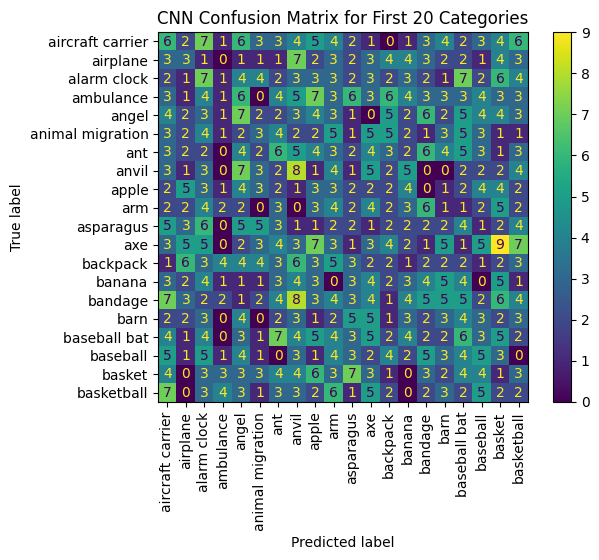

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_classes, predicted_classes)

categories_to_display = 20
cm_subset = cm[:categories_to_display, :categories_to_display]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_subset, display_labels=[QuickDrawData().drawing_names[i] for i in range(categories_to_display)])
disp.plot(xticks_rotation='vertical')
plt.title(f"CNN Confusion Matrix for First {categories_to_display} Categories")
plt.show()
